In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:

df=pd.read_csv('wines_SPA.csv')
df

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
7495,Contino,Reserva,2016,4.2,392,Espana,Rioja,19.98,Rioja Red,4.0,3.0
7496,Conreria d'Scala Dei,Les Brugueres,2018,4.2,390,Espana,Priorato,16.76,Priorat Red,4.0,3.0
7497,Mustiguillo,Finca Terrerazo,2017,4.2,390,Espana,El Terrerazo,24.45,Red,4.0,3.0
7498,Matarromera,Gran Reserva,2011,4.2,389,Espana,Ribera del Duero,64.50,Ribera Del Duero Red,5.0,3.0


In [3]:
#Display the datatype of each column.
df.dtypes

winery          object
wine            object
year            object
rating         float64
num_reviews      int64
country         object
region          object
price          float64
type            object
body           float64
acidity        float64
dtype: object

In [4]:
df.isnull().sum()

winery            0
wine              0
year              2
rating            0
num_reviews       0
country           0
region            0
price             0
type            545
body           1169
acidity        1169
dtype: int64

In [5]:
# Dropping rows with missing 'year'
df = df.dropna(subset=['year'])
df.isnull().sum()

winery            0
wine              0
year              0
rating            0
num_reviews       0
country           0
region            0
price             0
type            545
body           1169
acidity        1169
dtype: int64

In [7]:
# Correctly align the indices when imputing missing 'type' with the most common type within each region
most_common_type = df.groupby('region')['type'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
df['type'] = df['type'].fillna(most_common_type)
df.isnull().sum()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4220\3817102460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].fillna(most_common_type)


winery            0
wine              0
year              0
rating            0
num_reviews       0
country           0
region            0
price             0
type              0
body           1169
acidity        1169
dtype: int64

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Function to impute missing values using RandomForestRegressor
def impute_missing_values(df, target):
    # Splitting data into training and prediction sets
    not_null_df = df[df[target].notnull()]
    is_null_df = df[df[target].isnull()]
    
    # Features for prediction (excluding the target column and any other columns that won't help with prediction)
    features = df.columns.drop([target, 'winery', 'wine', 'year', 'country', 'region', 'type'])
    
    # Preparing the training data
    X_train = not_null_df[features]
    y_train = not_null_df[target]
    
    # Preparing the prediction data
    X_predict = is_null_df[features]
    
    # Train the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict the missing values
    predicted_values = rf.predict(X_predict)
    
    # Fill in the missing values in the original dataframe
    df.loc[df[target].isnull(), target] = predicted_values
    return df

# Impute missing 'body' values
df = impute_missing_values(df, 'body')

# Impute missing 'acidity' values
df = impute_missing_values(df, 'acidity')


In [9]:
df.isnull().sum()



winery         0
wine           0
year           0
rating         0
num_reviews    0
country        0
region         0
price          0
type           0
body           0
acidity        0
dtype: int64

In [10]:
import numpy as np

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detect outliers in numerical features
numerical_features = ['rating', 'num_reviews', 'price', 'body', 'acidity']
outliers = {}
for feature in numerical_features:
    outliers[feature] = detect_outliers_iqr(df, feature)
    print(f"Number of outliers in {feature}: {len(outliers[feature])}")

# Remove outliers from the dataset
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]


Number of outliers in rating: 1819
Number of outliers in num_reviews: 1918
Number of outliers in price: 537
Number of outliers in body: 2514
Number of outliers in acidity: 475


In [13]:
import numpy as np

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the 'price' column
df = remove_outliers_iqr(df, 'price')

df.shape


(2863, 11)

In [14]:
numerical_features = ['rating', 'num_reviews', 'price', 'body', 'acidity']
outliers = {}
for feature in numerical_features:
    outliers[feature] = detect_outliers_iqr(df, feature)
    print(f"Number of outliers in {feature}: {len(outliers[feature])}")

Number of outliers in rating: 0
Number of outliers in num_reviews: 0
Number of outliers in price: 0
Number of outliers in body: 0
Number of outliers in acidity: 0


In [15]:
df.drop(index=1990,inplace=True)
df

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
1996,Portal del Priorat,Clos del Portal Negre de Negres,2018,4.2,429,Espana,Priorato,21.70,Priorat Red,4.0,3.0
1997,Castillo Perelada,Monastrell - Syrah Finca Espolla,2016,4.2,424,Espana,Emporda,13.95,Red,4.0,3.0
2000,La Vicalanda,Reserva,2015,4.2,420,Espana,Rioja,17.50,Rioja Red,4.0,3.0
2001,Enrique Mendoza,Santa Rosa,2017,4.2,420,Espana,Alicante,18.90,Red,4.0,3.0
2002,Clos Pons,Roc Nu,2011,4.2,420,Espana,Costers del Segre,23.95,Red,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
7490,Binigrau,Nounat,2020,4.2,404,Espana,Mallorca,19.90,Red,4.0,3.0
7491,Ramon Bilbao,Mirto,2011,4.2,402,Espana,Rioja,28.53,Rioja Red,4.0,3.0
7495,Contino,Reserva,2016,4.2,392,Espana,Rioja,19.98,Rioja Red,4.0,3.0
7496,Conreria d'Scala Dei,Les Brugueres,2018,4.2,390,Espana,Priorato,16.76,Priorat Red,4.0,3.0


In [23]:
# Calculate the mode of the 'year' column
mode_year = df['year'].mode()[0]

# Replace 'N.V.' with the mode
df['year'] = df['year'].replace('N.V.', mode_year)

In [25]:
df['year'].unique()

array(['2018', '2016', '2015', '2017', '2011', '2012', '2020'],
      dtype=object)

In [16]:
# Measures of central tendency
central_tendency = df[['rating', 'num_reviews', 'price', 'body', 'acidity']].mean()
print("Mean:\n", central_tendency)

# Median
median = df[['rating', 'num_reviews', 'price', 'body', 'acidity']].median()
print("\nMedian:\n", median)

# Mode
mode = df[['rating', 'num_reviews', 'price', 'body', 'acidity']].mode().iloc[0]
print("\nMode:\n", mode)



Mean:
 rating           4.200000
num_reviews    406.936758
price           19.528809
body             4.000000
acidity          3.000000
dtype: float64

Median:
 rating           4.2
num_reviews    407.0
price           19.9
body             4.0
acidity          3.0
dtype: float64

Mode:
 rating           4.2
num_reviews    420.0
price            7.1
body             4.0
acidity          3.0
Name: 0, dtype: float64


In [17]:
# Measures of dispersion
dispersion = df[['rating', 'num_reviews', 'price', 'body', 'acidity']].std()
print("\nStandard Deviation:\n", dispersion)

# Variance
variance = df[['rating', 'num_reviews', 'price', 'body', 'acidity']].var()
print("\nVariance:\n", variance)



Standard Deviation:
 rating          0.000000
num_reviews    10.876665
price           6.035272
body            0.000000
acidity         0.000000
dtype: float64

Variance:
 rating           0.000000
num_reviews    118.301836
price           36.424504
body             0.000000
acidity          0.000000
dtype: float64


In [18]:

# Grouping by country and region
grouped_data = df.groupby(['country', 'region']).agg({'price': 'mean', 'rating': 'mean', 'num_reviews': 'sum'})
print("\nGrouped Data:\n", grouped_data.head(10))



Grouped Data:
                                 price  rating  num_reviews
country region                                            
Espana  Alicante            18.900000     4.2        92400
        Costers del Segre   23.950000     4.2        92400
        El Terrerazo        24.450000     4.2        85800
        Emporda             13.950000     4.2          424
        Jerez-Xeres-Sherry   7.100000     4.2        89100
        Mallorca            19.900000     4.2        88880
        Priorato            16.782353     4.2        86229
        Ribeiro             11.950000     4.2        89540
        Rioja               21.813333     4.2       539880


Which country produces the highest-rated wines on average?

In [19]:
average_rating_by_country = df.groupby('country')['rating'].mean().sort_values(ascending=False)
print("Country with the highest average rating:", average_rating_by_country.idxmax())


Country with the highest average rating: Espana


 Is there a correlation between the price of wines and their ratings?

In [20]:
correlation_price_rating = df['price'].corr(df['rating'])
print("Correlation between price and rating:", correlation_price_rating)


Correlation between price and rating: nan


What are the top regions in terms of the number of reviews received?


In [21]:
top_regions_reviews = df.groupby('region')['num_reviews'].sum().nlargest(5)
print("Top regions by number of reviews:\n", top_regions_reviews)


Top regions by number of reviews:
 region
Rioja                 539880
Alicante               92400
Costers del Segre      92400
Ribeiro                89540
Jerez-Xeres-Sherry     89100
Name: num_reviews, dtype: int64


Which countries produce the most expensive wines on average?

In [22]:
average_price_by_country = df.groupby('country')['price'].mean().sort_values(ascending=False)
print("Countries producing the most expensive wines on average:\n", average_price_by_country.head(5))



Countries producing the most expensive wines on average:
 country
Espana    19.528809
Name: price, dtype: float64


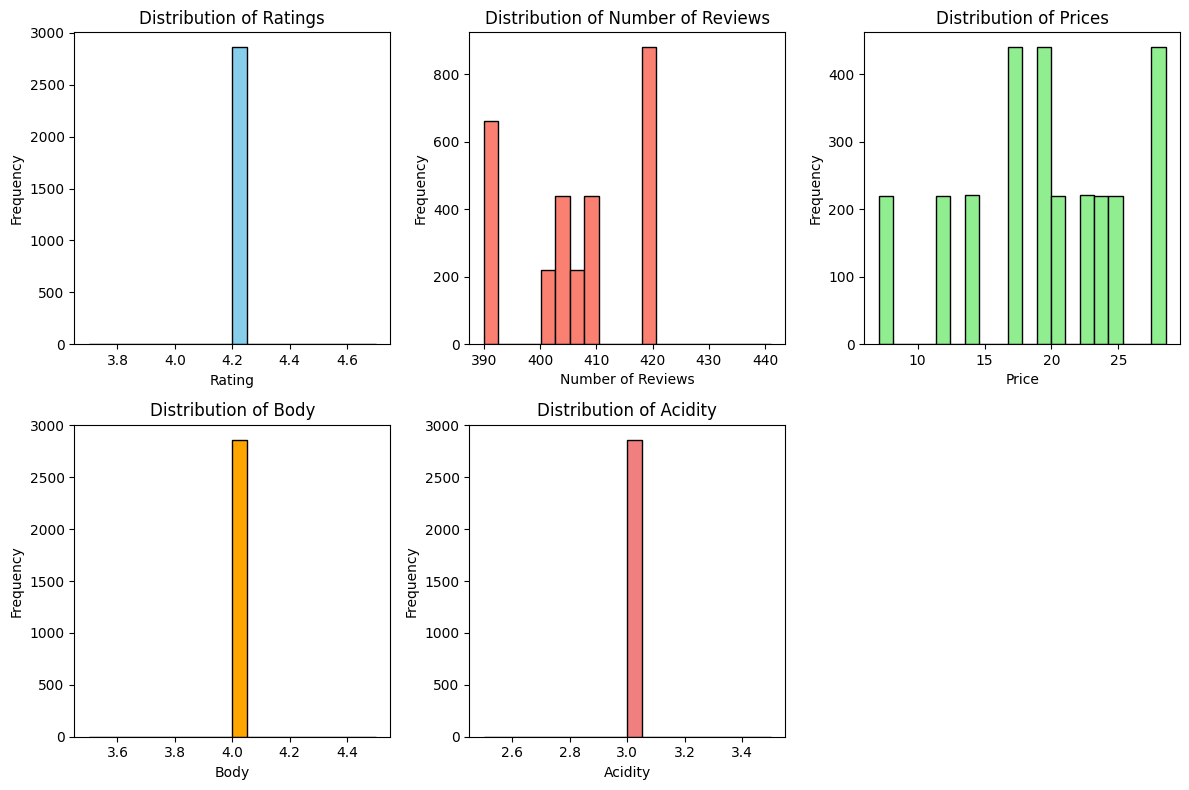

In [53]:
import matplotlib.pyplot as plt

# Histograms of numerical features
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.hist(df['rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.hist(df['num_reviews'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
plt.hist(df['price'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.hist(df['body'], bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Body')
plt.xlabel('Body')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(df['acidity'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Acidity')
plt.xlabel('Acidity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


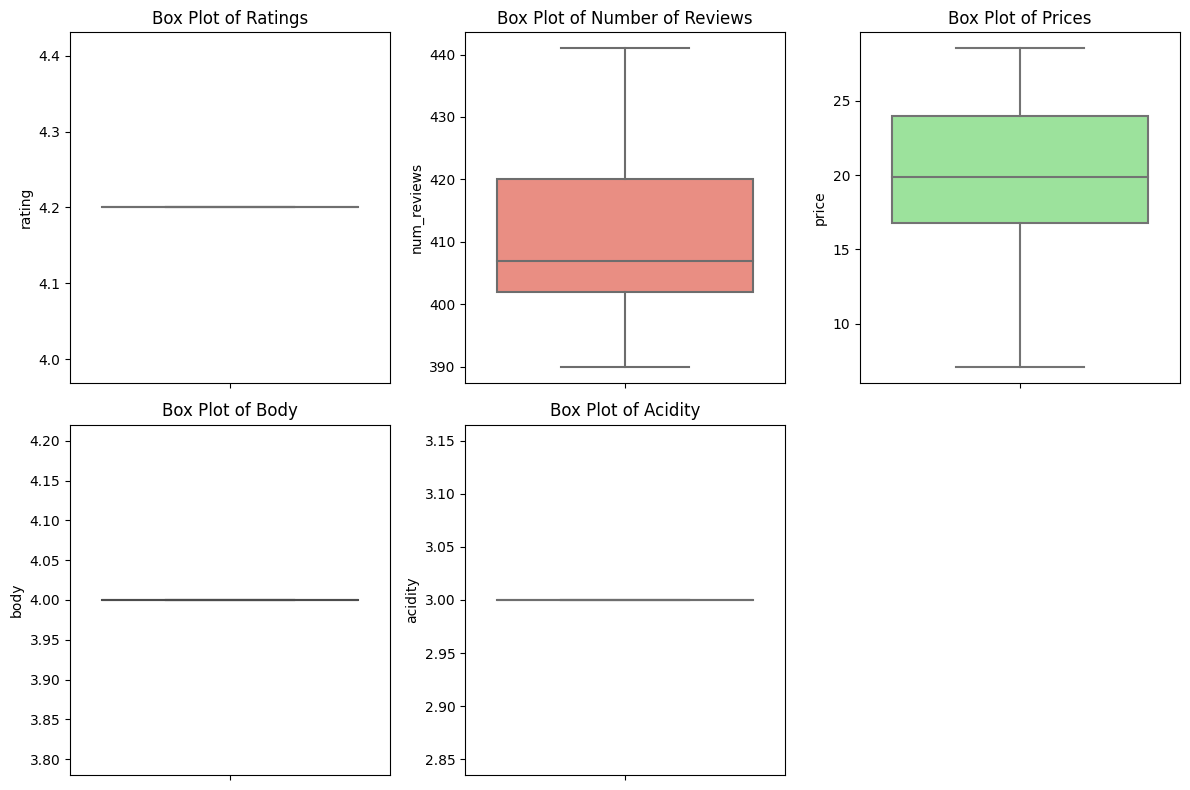

In [54]:
# Box plots of numerical features
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
sns.boxplot(y='rating', data=df, color='skyblue')
plt.title('Box Plot of Ratings')

plt.subplot(2, 3, 2)
sns.boxplot(y='num_reviews', data=df, color='salmon')
plt.title('Box Plot of Number of Reviews')

plt.subplot(2, 3, 3)
sns.boxplot(y='price', data=df, color='lightgreen')
plt.title('Box Plot of Prices')

plt.subplot(2, 3, 4)
sns.boxplot(y='body', data=df, color='orange')
plt.title('Box Plot of Body')

plt.subplot(2, 3, 5)
sns.boxplot(y='acidity', data=df, color='lightcoral')
plt.title('Box Plot of Acidity')

plt.tight_layout()
plt.show()


How does the distribution of wine prices vary between red and white wines?

<Figure size 800x600 with 0 Axes>

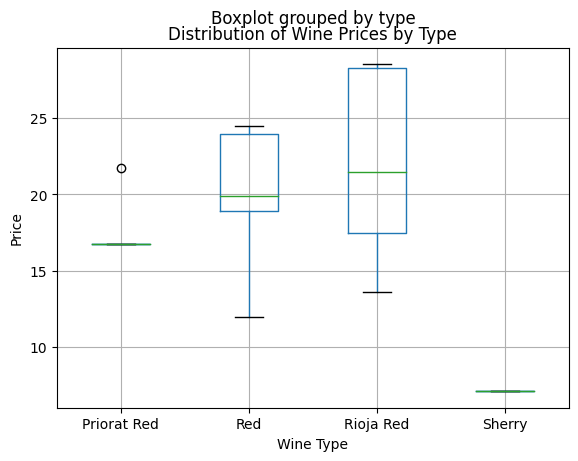

In [60]:
plt.figure(figsize=(8, 6))
df.boxplot(column='price', by='type')
plt.title('Distribution of Wine Prices by Type')
plt.ylabel('Price')
plt.xlabel('Wine Type')
plt.grid(True)
plt.show()


Is there a relationship between the price of wine and the number of reviews it receives?

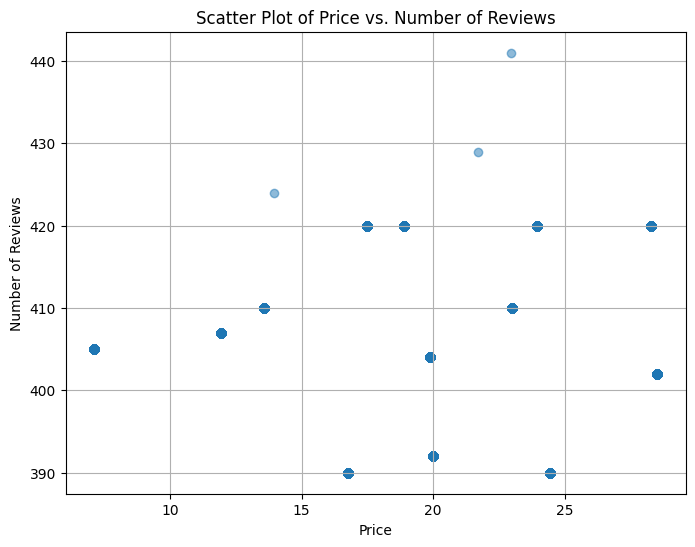

In [55]:
# Scatter plot of price vs. num_reviews
plt.figure(figsize=(8, 6))
plt.scatter(df['price'], df['num_reviews'], alpha=0.5)
plt.title('Scatter Plot of Price vs. Number of Reviews')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


In [63]:
import plotly.graph_objects as go
import seaborn as sns

# Define a color palette for each wine type
palette = {'Priorat Red': 'rgb(255, 0, 0)', 'Rioja Red': 'rgb(0, 0, 255)', 'Sherry': 'rgb(0, 255, 0)'}  # Add more colors if needed

# Map the wine type to colors
df['color'] = df['type'].map(palette)

# Create an interactive scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['price'],
    y=df['body'],
    mode='markers',
    marker=dict(color=df['color']),
    text=df['wine'],  # Hover text
    hoverinfo='text+x+y',  # Show wine name, price, and body on hover
    name='Price vs. Body'
))

fig.update_layout(
    title='Interactive Scatter Plot: Price vs. Body',
    xaxis_title='Price',
    yaxis_title='Body',
    legend_title='Wine Type',
    hoverlabel=dict(bgcolor='white', font_size=12),  # Hover label appearance
    showlegend=True
)

fig.show()


In [64]:
df['type'].unique()

array(['Red', 'Priorat Red', 'Rioja Red', 'Sherry'], dtype=object)

In [67]:
from scipy.stats import ttest_ind

# Splitting the dataset into two groups based on price
below_50 = df[df['price'] < 50]['num_reviews']
above_50 = df[df['price'] >= 50]['num_reviews']

# Performing the t-test
t_statistic, p_value = ttest_ind(below_50, above_50, equal_var=False)

# Output the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in the mean number of reviews between wines below and above $50.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the mean number of reviews between wines below and above $50.")


T-statistic: nan
P-value: nan
Fail to reject the null hypothesis: There is no significant difference in the mean number of reviews between wines below and above $50.


In [68]:
# Summary statistics for wines priced below $50
print("Summary statistics for wines below $50:")
print(below_50.describe())

# Summary statistics for wines priced above $50
print("\nSummary statistics for wines above $50:")
print(above_50.describe())


Summary statistics for wines below $50:
count    2863.000000
mean      406.948655
std        10.893382
min       390.000000
25%       402.000000
50%       407.000000
75%       420.000000
max       441.000000
Name: num_reviews, dtype: float64

Summary statistics for wines above $50:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: num_reviews, dtype: float64


In [77]:
from scipy.stats import f_oneway

# Define the regions
regions = ['Pla de Bages', 'Priorato', 'Emporda', 'Rioja', 'Alicante',
           'Costers del Segre', 'Ribeiro', 'Jerez-Xeres-Sherry', 'Mallorca',
           'El Terrerazo']

# Subset the data for each region
region_data = [df[df['region'] == region]['price'] for region in regions]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*region_data)

# Define significance level
alpha = 0.05

# Print results
print("F-statistic:", f_statistic)
print("P-value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the mean price of wines across different regions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the mean price of wines across different regions.")


F-statistic: 524.601845177911
P-value: 0.0
Reject the null hypothesis: There is a significant difference in the mean price of wines across different regions.


In [78]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient
corr_coef, p_value = pearsonr(df['price'], df['num_reviews'])

# Print results
print("Pearson correlation coefficient:", corr_coef)
print("P-value:", p_value)

# Define significance level
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between the price of wines and the number of reviews they receive.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between the price of wines and the number of reviews they receive.")


Pearson correlation coefficient: 0.07622342143022519
P-value: 4.452571601900169e-05
Reject the null hypothesis: There is a significant correlation between the price of wines and the number of reviews they receive.


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Assuming X contains your feature matrix and y contains the target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regression
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)
rf_predictions = rf_regressor.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
print("Random Forest Regression RMSE:", rf_rmse)

# Gradient Boosting Regression
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)
gb_predictions = gb_regressor.predict(X_test)
gb_rmse = mean_squared_error(y_test, gb_predictions, squared=False)
print("Gradient Boosting Regression RMSE:", gb_rmse)


C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Linear Regression RMSE: 8.881784197001252e-16
Random Forest Regression RMSE: 1.865174681370263e-14


C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [83]:
df.drop(columns=['color'],inplace=True)

In [84]:
df

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
1990,Abadal,3.9,2016,4.2,441,Espana,Pla de Bages,22.95,Red,4.0,3.0
1996,Portal del Priorat,Clos del Portal Negre de Negres,2018,4.2,429,Espana,Priorato,21.70,Priorat Red,4.0,3.0
1997,Castillo Perelada,Monastrell - Syrah Finca Espolla,2016,4.2,424,Espana,Emporda,13.95,Red,4.0,3.0
2000,La Vicalanda,Reserva,2015,4.2,420,Espana,Rioja,17.50,Rioja Red,4.0,3.0
2001,Enrique Mendoza,Santa Rosa,2017,4.2,420,Espana,Alicante,18.90,Red,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
7490,Binigrau,Nounat,2020,4.2,404,Espana,Mallorca,19.90,Red,4.0,3.0
7491,Ramon Bilbao,Mirto,2011,4.2,402,Espana,Rioja,28.53,Rioja Red,4.0,3.0
7495,Contino,Reserva,2016,4.2,392,Espana,Rioja,19.98,Rioja Red,4.0,3.0
7496,Conreria d'Scala Dei,Les Brugueres,2018,4.2,390,Espana,Priorato,16.76,Priorat Red,4.0,3.0


In [29]:
# One-hot encode categorical columns
X = pd.get_dummies(df.drop(columns=['num_reviews','winery','wine','country']), drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_predictions = linear_reg.predict(X_test)
linear_reg_rmse = mean_squared_error(y_test, linear_reg_predictions, squared=False)
print("Linear Regression RMSE:", linear_reg_rmse)



Linear Regression RMSE: 0.07864901869651054


C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


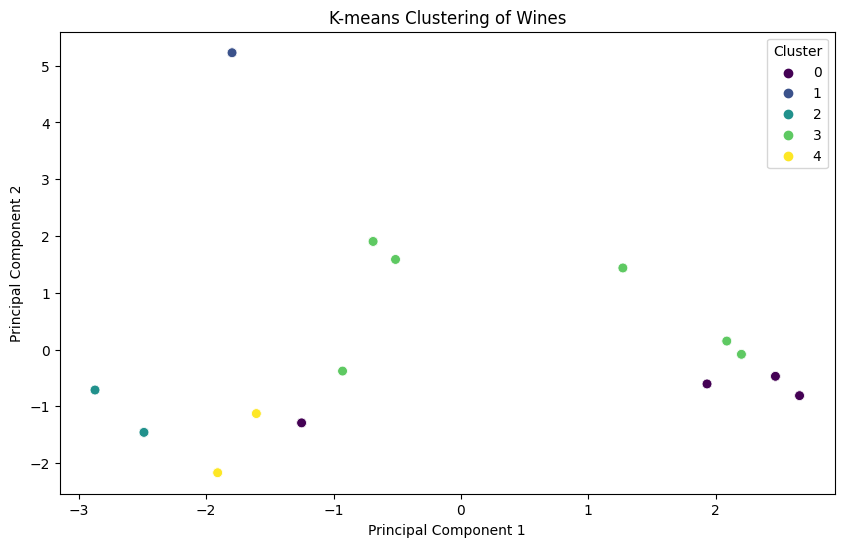

In [36]:
#One-hot encode categorical columns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
df['pc1'] = principal_components[:, 0]
df['pc2'] = principal_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster', palette='viridis', s=50)
plt.title('K-means Clustering of Wines')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

